In [7]:
import numpy as np
from IPython.display import display, Image as IPImage
from PIL import Image
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.utils import get_action_masks

from utils import DATA_DIR
from utils.rl.env import LoLDraftEnv, SelfPlayWrapper, action_mask_fn
from utils.rl.visualizer import integrate_with_env

# Load the trained model
model = MaskablePPO.load(f"{DATA_DIR}/lol_draft_ppo")

# Create and wrap the environment
env = LoLDraftEnv()
env = integrate_with_env(LoLDraftEnv)()
env = SelfPlayWrapper(env)
env = ActionMasker(env, action_mask_fn)
env = DummyVecEnv([lambda: env])

Reset called
Reset called


Reset called
Reset called
[0.55097884]
Blue ordered picks non-zero indices: (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
Red ordered picks non-zero indices: (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


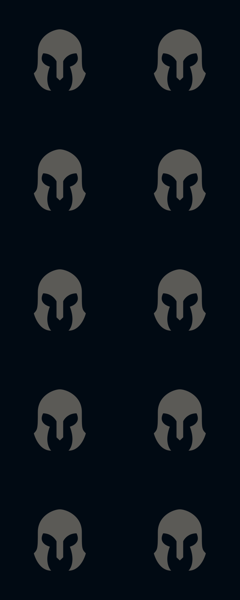

In [8]:
from IPython.display import display, Image as IPImage
from io import BytesIO

# Reset the environment
obs = env.reset()
done = False

while not done:
    # Get the action mask
    action_masks = get_action_masks(env)

    # Use the action_masks when predicting the action
    action, _states = model.predict(obs, action_masks=action_masks, deterministic=True)

    # Step the environment
    obs, reward, done, info = env.step(action)

    if done[0]:  # DummyVecEnv returns a list of done flags
        print(reward)
        blue_non_zero_indices = np.nonzero(obs["blue_ordered_picks"])
        red_non_zero_indices = np.nonzero(obs["red_ordered_picks"])
        print("Blue ordered picks non-zero indices:", blue_non_zero_indices)
        print("Red ordered picks non-zero indices:", red_non_zero_indices)
        # Get the final render
        image_data = env.envs[0].render()

        if image_data is not None:
            display(IPImage(data=image_data))
        else:
            print("Draft is not complete or visualization is not available.")